## Imports

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from sqlalchemy import create_engine, MetaData, text
import json
from io import StringIO

---

## Carga del dataset

In [ ]:
# Optamos por cargar el dataset desde un archivo excel que obtuvimos del sitio oficial del SMN: https://www.smn.gob.ar/descarga-de-datos. 
 # Saltamos las primeras 4 filas porque contienen información no relevante para el análisis.

df_wide = pd.read_excel("Estadísticas normales Datos abiertos 1991-2020.xlsx", skiprows=4)


---

## Limpieza del dataset previa al EDA

Encontramos dos problemas iniciales con el dataset elegido: 
1. La forma en que se indican los datos faltantes es con la indicación "S/D", no reconocida por Pandas. 

2. La información se encuentra en un formato ancho ("wide format") donde no cumple con el formato "tidy" ideal para modelos de ML. 

In [ ]:
# Primero solucionamos el problema de la referencia a los valores faltantes.
for col in df_wide.columns[2:]:
    df_wide[col] = (
        df_wide[col]
        .replace("S/D", pd.NA)          
    )
df_wide.head()

In [ ]:
#Ahora solucionamos el segundo problema transformando el dataset en un formato long en el que cada variable tenga su propia columna 
# y cada observación su propia fila.

# Convertimos de formato wide a long con el método melt de pandas.,
df_long= df_wide.melt(id_vars=['Estación', 'Variable'], var_name='Mes', value_name='Valor')
# Pivotear para que las métricas sean columnas
df_tidy = df_long.pivot_table(index=['Estación', 'Mes'], columns='Variable', values='Valor').reset_index()

#Simplificamos algunos nombres de columnas.
df_tidy = df_tidy.rename(columns={
    'Frecuencia de días con Precipitación superior a 1.0 mm': 'Prec. > a 1.0 mm',
    'Humedad relativa (%)': 'Humedad relativa',
    'Nubosidad total (octavos)': 'Nubosidad total',
    'Precipitación (mm)': 'Precipitación',
    'Temperatura (°C)': 'Temperatura',
    'Temperatura máxima (°C)': 'Temperatura Máx.',
    'Temperatura mínima (°C)': 'Temperatura Mín.',
    'Velocidad del Viento (km/h) (2011-2020)': 'Viento'
})

df_tidy.head()

Luego de esto podemos ver la diferencia entre cómo estaban arreglados los datos antes y cómo lo están ahora:

Arreglo inicial: 
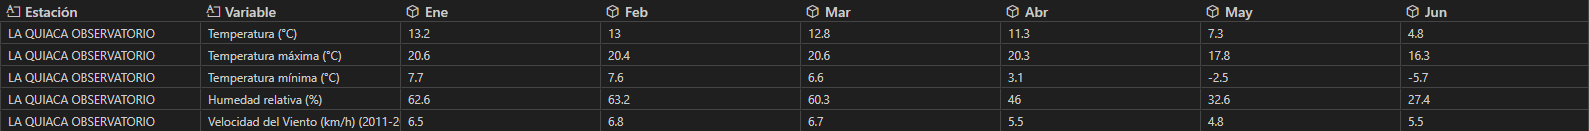

Arreglo tidy: 
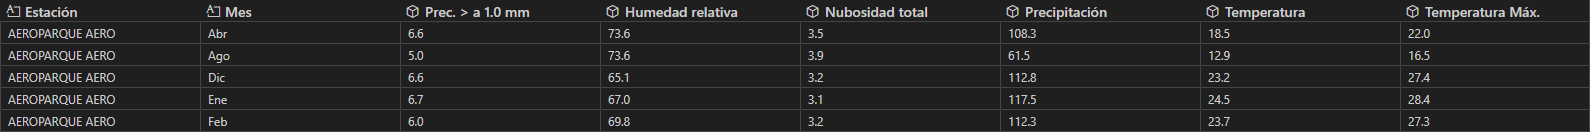

Puede notarse cómo ahora cada variable tiene su propia columna haciendo más fácil la selección de las Features y de la variable objetivo para el entrenamiento. Las primeras dos columnas actúan como una doble ID para las entradas, formadas por "Estación" + "Mes", de esta manera cada observación
corresponde a una estación determinada en un mes determinado. 

---

## EDA

#### Descripción del dataset 

| Columna            | Descripción                                                                         |
| -------------      | ------------------------------------------------------------------------------------|
| `Estación`         | El nombre de la estación desde donde se tomaron los datos.                          |
| `Mes`              | El mes al que corresponden las mediciones.                                          |
| Mediciones         | ------------------------------------------------------------------------------------|
| `Prec. > a 1.0 mm` | Cantidad de días que llovió más de 1 milímetro.                                     |
| `Humedad relativa` | La humedad relativa.                                                                | 
| `Nubosidad total`  | La nubosidad, expresada en octavos.                                                 | 
| `Precipitación`    | La precipitación, en milímetros.                                                    | 
| `Temperatura`      | La temperatura, en °C.                                                              | 
| `Temperatura Máx.` | La temperatura máxima, en °C.                                                       | 
| `Temperatura Mín.` | La temperatura mínima, en °C.                                                       | 
| `Viento`           | La velocidad del viento, en km/h.                                                   | 

In [ ]:
# Número de observaciones
df_tidy.info()
